## Investigating exposure-dependent immune acquisition
This is a notebook showing how we can explore the impact of different scenario input variables on outcomes.

Specifically, we are going to investigate how exposure-dependent acquisition of immunity -- as well as overall exposure rate + symptom-triggered treatment -- impact the relative proportions of human-to-mosquito infectiousness from different age groups.

In [1]:
from seasonal_challenge import monthly_eir_challenge, plot_timeseries, plot_heatmap

### Seasonal infectious challenge

Using a monthly profile of entomological inoculation rates (EIR), we will randomly challenge an individual with a probability of infectious bites every day -- corrected for the surface-area age-dependent biting risk assuming that t=0 is a newborn.

We then use our imported helper function to plot the state of the simulated individual over several years of repeated seasonal challenge.

In the lower panel is the number of concurrent infections within the individual -- making it clearer when incident infections arise during the high-transmission season.

Also note how superinfection results in additional waves of higher parasite density than single infections.

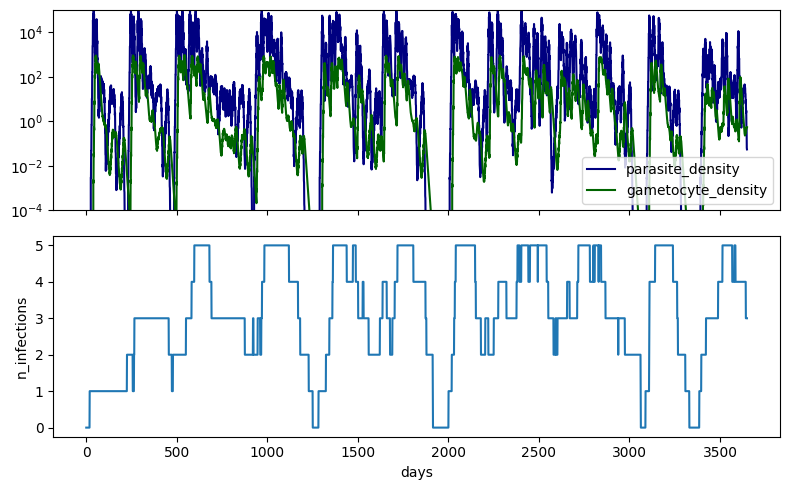

In [2]:
rafin_marke_monthly_eirs = [1, 1, 0.5, 1, 1, 2, 3.875, 7.75, 15.0, 3.875, 1, 1]

df = monthly_eir_challenge(
    duration=365*10,
    monthly_eirs=rafin_marke_monthly_eirs)

plot_timeseries(df)

#### Increasing exposure rate

Below, we re-run the same scenario, but with an increased overall rate of exposure to see its effect on the time series.

As the individual grows older, and their age-dependent biting rates increases, they are exposed to sufficiently many infectious challenges during even the low season that they sustain the max number of concurrent infections -- and correspondingly higher parasite densities -- during most of the year.

We also can note the faster acquired immunity by comparing the lower average peak parasite density on incident infection at older ages compared to the lower-exposure scenario above.

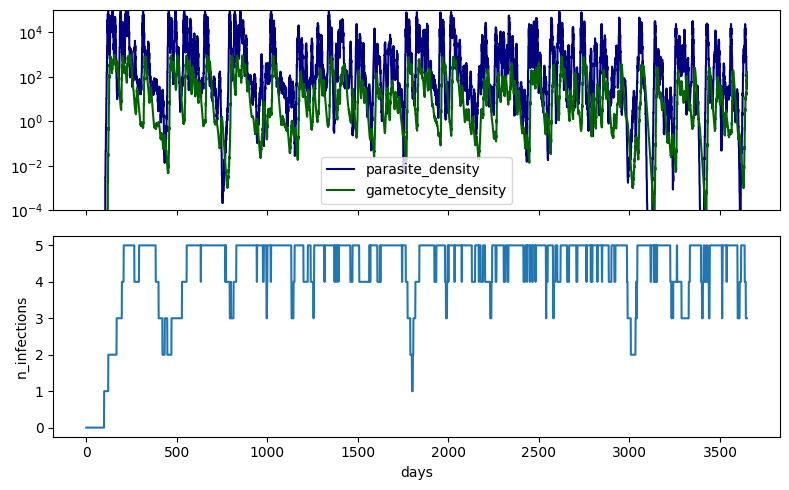

In [3]:
df_5x = monthly_eir_challenge(
    duration=365*10,
    monthly_eirs=[5*x for x in rafin_marke_monthly_eirs])
plot_timeseries(df_5x)

#### Adding symptomatic treatment

Now let's explore adding a fever-triggered infection-clearance function (crudely approximating drug treatment).

The `monthly_eir_challenge` helper function has an optional `callback` argument, which at the end of every timestep (before the reporting) will call an arbitrary function on the `IntrahostComponent` object.

So below, we can start with a simple function that treats an individual if their `fever_temperature` is above a threshold value.

In [4]:
def simple_treat(ic):
    if ic.fever_temperature > 38.5:
        ic.treat()

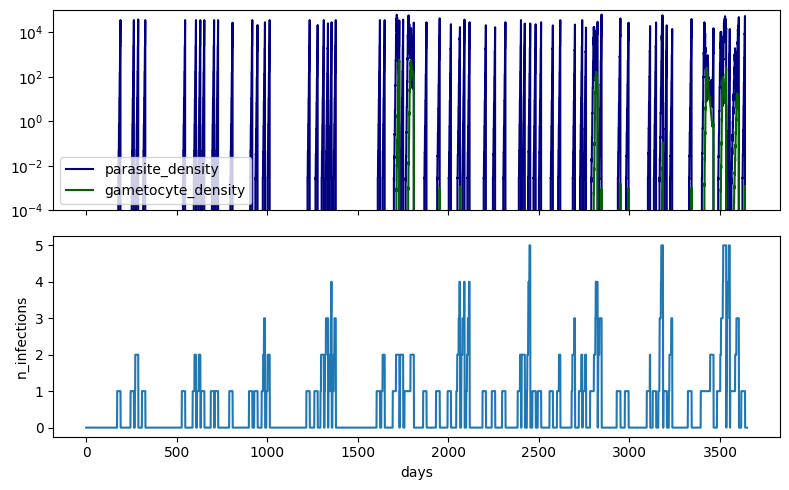

In [5]:
df_simple_treat = monthly_eir_challenge(
    duration=365*10,
    monthly_eirs=rafin_marke_monthly_eirs,
    callback=simple_treat)
plot_timeseries(df_simple_treat)

Alternatively, we can code up a slightly more complex treatment logic -- analogous to the code in EMOD, in which unique clinical episodes are only counted following a veto period of days with fever below a lower threshold.

Here, we use a `ComplexTreatment` class to remember how many days it has been between incidents, the built-in `__call__` function to match the API in the helper function, and `numpy.random` to probabilistically trigger treatment on new fever episodes after sufficient veto period.

In [6]:
import numpy as np

Clinical_Fever_Threshold_High = 38.5
Clinical_Fever_Threshold_Low = 37.5
Min_Days_Between_Clinical_Incidents = 14

class ComplexTreatment:

    def __init__(self, prob_treat):
        self.symptomatic = False
        self.days_since_incident = 0
        self.prob_treat = prob_treat

    def __call__(self, ic):
        fever = ic.fever_temperature

        if self.symptomatic:
            if fever > Clinical_Fever_Threshold_Low:
                self.days_since_incident = 0
            else:
                self.days_since_incident += 1
            if self.days_since_incident > Min_Days_Between_Clinical_Incidents:
                self.symptomatic = False

        elif fever > Clinical_Fever_Threshold_High:
            self.symptomatic = True
            if np.random.random() < self.prob_treat:
                ic.treat()
            


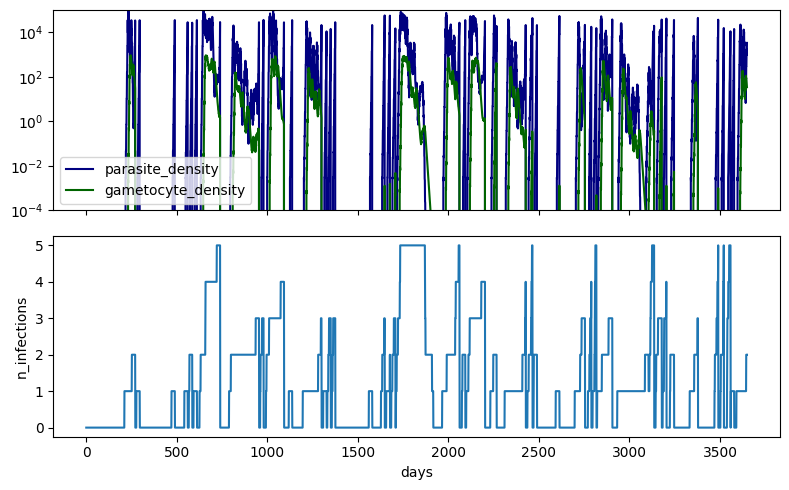

In [7]:
complex_treat = ComplexTreatment(prob_treat=0.8)

df_complex_treat = monthly_eir_challenge(
    duration=365*10,
    monthly_eirs=rafin_marke_monthly_eirs,
    callback=complex_treat)

plot_timeseries(df_complex_treat)

### Infectious Reservoir

To look more closely at what ages are contributing to the infectious reservoir in different scenarios, let's first run a longer time series into adulthood.

Stacking the parasite density into a heatmap of season-vs-age highlights the seasonal exposure term, the increased EIR at older ages, and the lower peak parasite densities with acquired immunity.

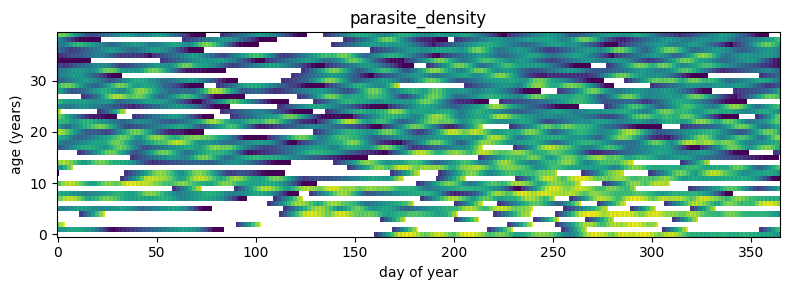

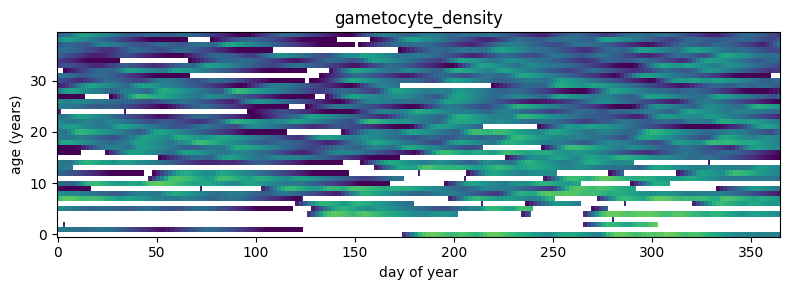

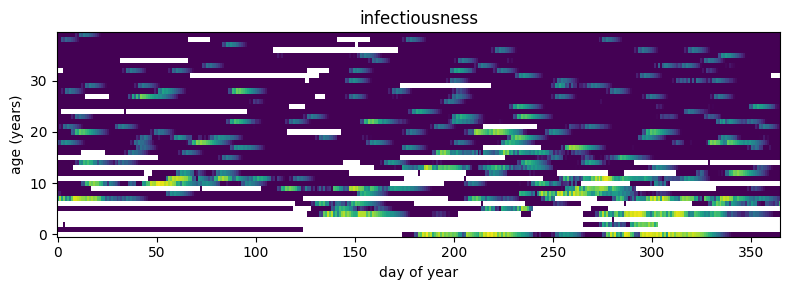

In [8]:
df40_complex_treat = monthly_eir_challenge(
    duration=365*40,
    monthly_eirs=rafin_marke_monthly_eirs,
    callback=complex_treat)

plot_heatmap(df40_complex_treat)
plot_heatmap(df40_complex_treat, channel='gametocyte_density')
plot_heatmap(df40_complex_treat, channel='infectiousness', vmin=0.01, vmax=1)

#### Custom infectiousness function

If we want, we can specify our own custom infectiousness function and explore the implications of different functional forms.

For example, we could do something more categorical like the following...

In [9]:
def custom_inf(g):
    if g > 100:
        return 0.2
    elif g > 1:
        return 0.02
    else:
        return 0

In [10]:
df40_complex_treat['custom_inf'] = df40_complex_treat.gametocyte_density.map(custom_inf)

In [11]:
df40_complex_treat.iloc[::30].head(20)

,parasite_density,gametocyte_density,fever_temperature,infectiousness,n_infections,custom_inf
days,,,,,,
0,0.000000,0.000000,37.000000,0.000000e+00,0.0,0.00
30,0.000000,0.000000,37.000000,0.000000e+00,0.0,0.00
60,0.000000,0.000000,37.000000,0.000000e+00,0.0,0.00
90,0.000000,0.000000,37.000000,0.000000e+00,0.0,0.00
120,0.000000,0.000000,37.000000,0.000000e+00,0.0,0.00
150,0.000000,0.000000,37.000000,0.000000e+00,0.0,0.00
180,31821.578125,7.910448,37.000023,3.130639e-02,1.0,0.02
210,12090.441406,69.267914,37.000202,2.425301e-01,2.0,0.02
240,635.078064,12.117342,37.194660,1.235848e-02,2.0,0.02


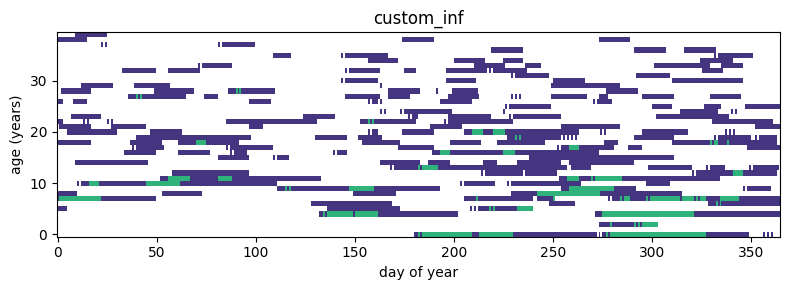

In [12]:
plot_heatmap(df40_complex_treat, channel='custom_inf', vmin=0.01, vmax=1)

#### Averaging over multiple individuals
To accumulate some aggregate statistics, let's try running our single-individual lifetime challenge scenarios multiple times, and then averaging the observables among the output table instances.

Note the function below is using 

In [13]:
import pandas as pd

n_individuals = 20

dfs = [monthly_eir_challenge(duration=365*40, monthly_eirs=rafin_marke_monthly_eirs, callback=complex_treat) for _ in range(n_individuals)]

df_mean = pd.concat(dfs).reset_index().groupby('days').mean()  # although note these are arithmetic means for all channels

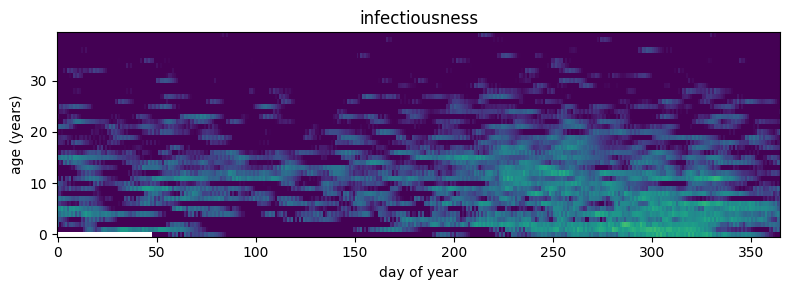

In [14]:
plot_heatmap(df_mean, channel='infectiousness', vmin=0.01, vmax=1)

And finally, we can average over the year and compare age groups directly...

Text(0.5, 1.0, 'Average human infectiousness per bite')

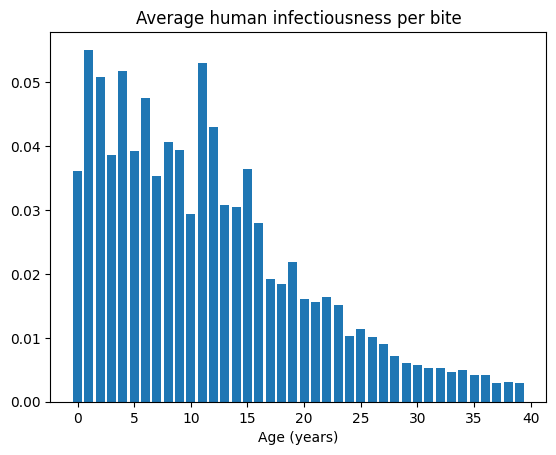

In [15]:
import matplotlib.pyplot as plt

inf_by_age = np.reshape(df_mean.infectiousness.values, (-1, 365)).mean(axis=1)
age = np.arange(len(inf_by_age))
plt.bar(age, inf_by_age)
plt.xlabel('Age (years)')
plt.title('Average human infectiousness per bite')
